In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [2]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])


class NMINSTImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy').astype(np.float32)
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        label_temp = np.zeros((10,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
        
    def set_stage(self, stage):
        self.stage = stage

In [3]:
from torch.utils.data import DataLoader
data = NMINSTImageDataset("./Datasety/train_MINST", transform=transforms)
generator1 = torch.Generator().manual_seed(42)
test_data, training_data = torch.utils.data.random_split(data, [0.3, 0.7], generator=generator1)

del data

In [4]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=-1.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(5, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet50_MINST-DVS_Hardtanh_ReLUmaxpool__128x128_FC2_128x128_pretrained_aug.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}'.format( correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [6]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes = 10).to("cuda")
print(model_resnet)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kerne

### Copy weights

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:

size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv

In [9]:
torch.autograd.set_detect_anomaly(True)
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=120,save_best=True, save_thr=90)

100%|██████████| 219/219 [00:55<00:00,  3.96it/s]


Epoch [1/120], Step [219/219], Loss: 3.3959, Accuracy: 0.1096
Accuracy of the network: 0.10033333333333333 Loss: 2.8537689853221813


100%|██████████| 219/219 [00:53<00:00,  4.10it/s]


Epoch [2/120], Step [219/219], Loss: 2.3945, Accuracy: 0.1643
Accuracy of the network: 0.22666666666666666 Loss: 2.0951075883621866


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [3/120], Step [219/219], Loss: 1.8798, Accuracy: 0.2293
Accuracy of the network: 0.25466666666666665 Loss: 1.936948906868062


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [4/120], Step [219/219], Loss: 1.7350, Accuracy: 0.2857
Accuracy of the network: 0.31666666666666665 Loss: 1.5927030355372327


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [5/120], Step [219/219], Loss: 1.5967, Accuracy: 0.3296
Accuracy of the network: 0.4086666666666667 Loss: 1.4455209234927564


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [6/120], Step [219/219], Loss: 1.4935, Accuracy: 0.3837
Accuracy of the network: 0.39366666666666666 Loss: 1.5512949202923065


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [7/120], Step [219/219], Loss: 1.3341, Accuracy: 0.4620
Accuracy of the network: 0.5563333333333333 Loss: 1.1602843112133918


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [8/120], Step [219/219], Loss: 1.2169, Accuracy: 0.5316
Accuracy of the network: 0.5923333333333334 Loss: 1.0706013187449028


100%|██████████| 219/219 [00:52<00:00,  4.13it/s]


Epoch [9/120], Step [219/219], Loss: 1.0187, Accuracy: 0.6197
Accuracy of the network: 0.7386666666666667 Loss: 0.7899982155637538


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [10/120], Step [219/219], Loss: 0.7616, Accuracy: 0.7269
Accuracy of the network: 0.8546666666666667 Loss: 0.4800522780798851


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [11/120], Step [219/219], Loss: 0.5028, Accuracy: 0.8317
Accuracy of the network: 0.8393333333333334 Loss: 0.44891261325237597


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [12/120], Step [219/219], Loss: 0.3852, Accuracy: 0.8763
Accuracy of the network: 0.9086666666666666 Loss: 0.29737371594664896


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [13/120], Step [219/219], Loss: 0.3190, Accuracy: 0.8990
Accuracy of the network: 0.9193333333333333 Loss: 0.2659690812864202


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [14/120], Step [219/219], Loss: 0.2715, Accuracy: 0.9154
Accuracy of the network: 0.9173333333333333 Loss: 0.2659866211420678


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [15/120], Step [219/219], Loss: 0.2403, Accuracy: 0.9310
Accuracy of the network: 0.9323333333333333 Loss: 0.23098595765359858


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [16/120], Step [219/219], Loss: 0.2141, Accuracy: 0.9350
Accuracy of the network: 0.9486666666666667 Loss: 0.18215149088188054


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [17/120], Step [219/219], Loss: 0.1925, Accuracy: 0.9400
Accuracy of the network: 0.9463333333333334 Loss: 0.18043968216218848


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [18/120], Step [219/219], Loss: 0.1655, Accuracy: 0.9519
Accuracy of the network: 0.9536666666666667 Loss: 0.1395094514765004


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [19/120], Step [219/219], Loss: 0.1613, Accuracy: 0.9514
Accuracy of the network: 0.953 Loss: 0.1495371762504603


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [20/120], Step [219/219], Loss: 0.1417, Accuracy: 0.9599
Accuracy of the network: 0.9623333333333334 Loss: 0.12869963905912765


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [21/120], Step [219/219], Loss: 0.1350, Accuracy: 0.9623
Accuracy of the network: 0.9723333333333334 Loss: 0.10283859026558856


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [22/120], Step [219/219], Loss: 0.1311, Accuracy: 0.9629
Accuracy of the network: 0.968 Loss: 0.10998311670536691


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [23/120], Step [219/219], Loss: 0.1181, Accuracy: 0.9669
Accuracy of the network: 0.97 Loss: 0.10857098589235163


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [24/120], Step [219/219], Loss: 0.1115, Accuracy: 0.9690
Accuracy of the network: 0.9706666666666667 Loss: 0.10504758476893952


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [25/120], Step [219/219], Loss: 0.1096, Accuracy: 0.9699
Accuracy of the network: 0.9743333333333334 Loss: 0.09476805654691255


100%|██████████| 219/219 [00:55<00:00,  3.92it/s]


Epoch [26/120], Step [219/219], Loss: 0.1020, Accuracy: 0.9701
Accuracy of the network: 0.967 Loss: 0.1225893188149054


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [27/120], Step [219/219], Loss: 0.0962, Accuracy: 0.9736
Accuracy of the network: 0.971 Loss: 0.10056618462376138


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [28/120], Step [219/219], Loss: 0.0892, Accuracy: 0.9759
Accuracy of the network: 0.9676666666666667 Loss: 0.10419246813956093


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [29/120], Step [219/219], Loss: 0.0916, Accuracy: 0.9757
Accuracy of the network: 0.9773333333333334 Loss: 0.09151505768061319


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [30/120], Step [219/219], Loss: 0.0830, Accuracy: 0.9777
Accuracy of the network: 0.9743333333333334 Loss: 0.0909767806965937


100%|██████████| 219/219 [00:50<00:00,  4.38it/s]


Epoch [31/120], Step [219/219], Loss: 0.0790, Accuracy: 0.9796
Accuracy of the network: 0.9753333333333334 Loss: 0.08987329624831042


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [32/120], Step [219/219], Loss: 0.0797, Accuracy: 0.9793
Accuracy of the network: 0.977 Loss: 0.08676022433854164


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [33/120], Step [219/219], Loss: 0.0789, Accuracy: 0.9789
Accuracy of the network: 0.9786666666666667 Loss: 0.08602142962131729


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [34/120], Step [219/219], Loss: 0.0729, Accuracy: 0.9826
Accuracy of the network: 0.9786666666666667 Loss: 0.08067432385770247


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [35/120], Step [219/219], Loss: 0.0630, Accuracy: 0.9859
Accuracy of the network: 0.9733333333333334 Loss: 0.08883530093713644


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [36/120], Step [219/219], Loss: 0.0657, Accuracy: 0.9839
Accuracy of the network: 0.9766666666666667 Loss: 0.0850116167851585


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [37/120], Step [219/219], Loss: 0.0682, Accuracy: 0.9823
Accuracy of the network: 0.9796666666666667 Loss: 0.07741131255046484


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [38/120], Step [219/219], Loss: 0.0667, Accuracy: 0.9824
Accuracy of the network: 0.978 Loss: 0.08019930057901334


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [39/120], Step [219/219], Loss: 0.0625, Accuracy: 0.9859
Accuracy of the network: 0.9746666666666667 Loss: 0.0841130459720784


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [40/120], Step [219/219], Loss: 0.0588, Accuracy: 0.9853
Accuracy of the network: 0.9783333333333334 Loss: 0.0760226445173488


100%|██████████| 219/219 [00:53<00:00,  4.13it/s]


Epoch [41/120], Step [219/219], Loss: 0.0576, Accuracy: 0.9864
Accuracy of the network: 0.9796666666666667 Loss: 0.07964920024684768


100%|██████████| 219/219 [00:53<00:00,  4.09it/s]


Epoch [42/120], Step [219/219], Loss: 0.0574, Accuracy: 0.9860
Accuracy of the network: 0.9783333333333334 Loss: 0.07990937387729262


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [43/120], Step [219/219], Loss: 0.0582, Accuracy: 0.9853
Accuracy of the network: 0.979 Loss: 0.07805628295829321


100%|██████████| 219/219 [00:52<00:00,  4.14it/s]


Epoch [44/120], Step [219/219], Loss: 0.0544, Accuracy: 0.9879
Accuracy of the network: 0.981 Loss: 0.07571024298073446


100%|██████████| 219/219 [00:52<00:00,  4.13it/s]


Epoch [45/120], Step [219/219], Loss: 0.0540, Accuracy: 0.9869
Accuracy of the network: 0.9746666666666667 Loss: 0.08173210128269931


100%|██████████| 219/219 [00:54<00:00,  4.04it/s]


Epoch [46/120], Step [219/219], Loss: 0.0521, Accuracy: 0.9863
Accuracy of the network: 0.978 Loss: 0.07721324636541466


100%|██████████| 219/219 [00:54<00:00,  4.04it/s]


Epoch [47/120], Step [219/219], Loss: 0.0518, Accuracy: 0.9879
Accuracy of the network: 0.9803333333333333 Loss: 0.07720482863604705


100%|██████████| 219/219 [00:54<00:00,  4.03it/s]


Epoch [48/120], Step [219/219], Loss: 0.0524, Accuracy: 0.9883
Accuracy of the network: 0.979 Loss: 0.07724624140029575


100%|██████████| 219/219 [00:54<00:00,  4.04it/s]


Epoch [49/120], Step [219/219], Loss: 0.0520, Accuracy: 0.9874
Accuracy of the network: 0.9786666666666667 Loss: 0.07870456503030468


100%|██████████| 219/219 [00:53<00:00,  4.06it/s]


Epoch [50/120], Step [219/219], Loss: 0.0503, Accuracy: 0.9887
Accuracy of the network: 0.9786666666666667 Loss: 0.07509490260061749


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [51/120], Step [219/219], Loss: 0.0531, Accuracy: 0.9881
Accuracy of the network: 0.9806666666666667 Loss: 0.07666309164995526


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [52/120], Step [219/219], Loss: 0.0513, Accuracy: 0.9880
Accuracy of the network: 0.9793333333333333 Loss: 0.07664031947546816


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [53/120], Step [219/219], Loss: 0.0497, Accuracy: 0.9887
Accuracy of the network: 0.979 Loss: 0.07420770345414256


100%|██████████| 219/219 [00:52<00:00,  4.14it/s]


Epoch [54/120], Step [219/219], Loss: 0.0508, Accuracy: 0.9883
Accuracy of the network: 0.979 Loss: 0.07367920494103368


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [55/120], Step [219/219], Loss: 0.0472, Accuracy: 0.9899
Accuracy of the network: 0.979 Loss: 0.07489159522439412


100%|██████████| 219/219 [00:53<00:00,  4.13it/s]


Epoch [56/120], Step [219/219], Loss: 0.0469, Accuracy: 0.9896
Accuracy of the network: 0.9793333333333333 Loss: 0.07331804785520789


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [57/120], Step [219/219], Loss: 0.0494, Accuracy: 0.9884
Accuracy of the network: 0.98 Loss: 0.07241514776932433


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [58/120], Step [219/219], Loss: 0.0496, Accuracy: 0.9877
Accuracy of the network: 0.979 Loss: 0.07285652053047051


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [59/120], Step [219/219], Loss: 0.0473, Accuracy: 0.9897
Accuracy of the network: 0.9806666666666667 Loss: 0.07136909749874092


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [60/120], Step [219/219], Loss: 0.0495, Accuracy: 0.9891
Accuracy of the network: 0.981 Loss: 0.07349192788031825


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [61/120], Step [219/219], Loss: 0.0472, Accuracy: 0.9894
Accuracy of the network: 0.98 Loss: 0.07144549682221198


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [62/120], Step [219/219], Loss: 0.0488, Accuracy: 0.9901
Accuracy of the network: 0.9806666666666667 Loss: 0.07116744964522251


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [63/120], Step [219/219], Loss: 0.0458, Accuracy: 0.9904
Accuracy of the network: 0.979 Loss: 0.07204756691576318


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [64/120], Step [219/219], Loss: 0.0449, Accuracy: 0.9909
Accuracy of the network: 0.9803333333333333 Loss: 0.07223643363512894


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [65/120], Step [219/219], Loss: 0.0466, Accuracy: 0.9887
Accuracy of the network: 0.9806666666666667 Loss: 0.0730599144850164


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [66/120], Step [219/219], Loss: 0.0473, Accuracy: 0.9900
Accuracy of the network: 0.982 Loss: 0.07017174000514949


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [67/120], Step [219/219], Loss: 0.0479, Accuracy: 0.9901
Accuracy of the network: 0.98 Loss: 0.07190750081567689


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [68/120], Step [219/219], Loss: 0.0478, Accuracy: 0.9889
Accuracy of the network: 0.9806666666666667 Loss: 0.0728086287928547


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [69/120], Step [219/219], Loss: 0.0452, Accuracy: 0.9907
Accuracy of the network: 0.9793333333333333 Loss: 0.07517399483340535


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [70/120], Step [219/219], Loss: 0.0451, Accuracy: 0.9906
Accuracy of the network: 0.9796666666666667 Loss: 0.0713344037958837


100%|██████████| 219/219 [00:53<00:00,  4.10it/s]


Epoch [71/120], Step [219/219], Loss: 0.0463, Accuracy: 0.9907
Accuracy of the network: 0.9793333333333333 Loss: 0.07218927818231602


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [72/120], Step [219/219], Loss: 0.0474, Accuracy: 0.9904
Accuracy of the network: 0.9783333333333334 Loss: 0.0721348041391119


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [73/120], Step [219/219], Loss: 0.0480, Accuracy: 0.9880
Accuracy of the network: 0.9803333333333333 Loss: 0.07069429428257207


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [74/120], Step [219/219], Loss: 0.0449, Accuracy: 0.9911
Accuracy of the network: 0.9823333333333333 Loss: 0.07093143224359509


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [75/120], Step [219/219], Loss: 0.0479, Accuracy: 0.9899
Accuracy of the network: 0.9803333333333333 Loss: 0.07226275541680924


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [76/120], Step [219/219], Loss: 0.0455, Accuracy: 0.9906
Accuracy of the network: 0.9796666666666667 Loss: 0.07362224695649236


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [77/120], Step [219/219], Loss: 0.0452, Accuracy: 0.9910
Accuracy of the network: 0.9836666666666667 Loss: 0.07158144881473259


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [78/120], Step [219/219], Loss: 0.0479, Accuracy: 0.9893
Accuracy of the network: 0.9806666666666667 Loss: 0.07159030645530909


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [79/120], Step [219/219], Loss: 0.0470, Accuracy: 0.9887
Accuracy of the network: 0.981 Loss: 0.0707741995401522


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [80/120], Step [219/219], Loss: 0.0452, Accuracy: 0.9909
Accuracy of the network: 0.983 Loss: 0.0730296991706053


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [81/120], Step [219/219], Loss: 0.0463, Accuracy: 0.9906
Accuracy of the network: 0.9816666666666667 Loss: 0.06992426722686976


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [82/120], Step [219/219], Loss: 0.0463, Accuracy: 0.9904
Accuracy of the network: 0.9806666666666667 Loss: 0.07115294109593998


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [83/120], Step [219/219], Loss: 0.0464, Accuracy: 0.9903
Accuracy of the network: 0.9806666666666667 Loss: 0.07192019193849349


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [84/120], Step [219/219], Loss: 0.0478, Accuracy: 0.9894
Accuracy of the network: 0.9803333333333333 Loss: 0.07178377836665258


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [85/120], Step [219/219], Loss: 0.0447, Accuracy: 0.9911
Accuracy of the network: 0.9816666666666667 Loss: 0.07310151393981056


100%|██████████| 219/219 [00:53<00:00,  4.13it/s]


Epoch [86/120], Step [219/219], Loss: 0.0468, Accuracy: 0.9901
Accuracy of the network: 0.98 Loss: 0.07218579574428657


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [87/120], Step [219/219], Loss: 0.0479, Accuracy: 0.9890
Accuracy of the network: 0.982 Loss: 0.0710709477834245


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [88/120], Step [219/219], Loss: 0.0465, Accuracy: 0.9900
Accuracy of the network: 0.9806666666666667 Loss: 0.07307135125503261


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [89/120], Step [219/219], Loss: 0.0465, Accuracy: 0.9907
Accuracy of the network: 0.9826666666666667 Loss: 0.07317230491799877


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [90/120], Step [219/219], Loss: 0.0433, Accuracy: 0.9901
Accuracy of the network: 0.9803333333333333 Loss: 0.07209563086879381


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [91/120], Step [219/219], Loss: 0.0466, Accuracy: 0.9904
Accuracy of the network: 0.9826666666666667 Loss: 0.07150208357563044


100%|██████████| 219/219 [00:52<00:00,  4.13it/s]


Epoch [92/120], Step [219/219], Loss: 0.0454, Accuracy: 0.9910
Accuracy of the network: 0.98 Loss: 0.07293297521809632


100%|██████████| 219/219 [00:53<00:00,  4.07it/s]


Epoch [93/120], Step [219/219], Loss: 0.0454, Accuracy: 0.9913
Accuracy of the network: 0.9833333333333333 Loss: 0.07277976737377491


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [94/120], Step [219/219], Loss: 0.0431, Accuracy: 0.9913
Accuracy of the network: 0.9793333333333333 Loss: 0.0742455935402912


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [95/120], Step [219/219], Loss: 0.0481, Accuracy: 0.9894
Accuracy of the network: 0.9796666666666667 Loss: 0.0709852051346543


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [96/120], Step [219/219], Loss: 0.0430, Accuracy: 0.9910
Accuracy of the network: 0.9803333333333333 Loss: 0.07147800197151113


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [97/120], Step [219/219], Loss: 0.0465, Accuracy: 0.9894
Accuracy of the network: 0.9816666666666667 Loss: 0.07130387989170056


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [98/120], Step [219/219], Loss: 0.0446, Accuracy: 0.9909
Accuracy of the network: 0.9806666666666667 Loss: 0.07133236188600038


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [99/120], Step [219/219], Loss: 0.0478, Accuracy: 0.9896
Accuracy of the network: 0.9826666666666667 Loss: 0.0721342629218038


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [100/120], Step [219/219], Loss: 0.0486, Accuracy: 0.9887
Accuracy of the network: 0.981 Loss: 0.0710219769599907


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [101/120], Step [219/219], Loss: 0.0459, Accuracy: 0.9899
Accuracy of the network: 0.9786666666666667 Loss: 0.07159256001815517


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [102/120], Step [219/219], Loss: 0.0454, Accuracy: 0.9900
Accuracy of the network: 0.981 Loss: 0.0723860855709682


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [103/120], Step [219/219], Loss: 0.0468, Accuracy: 0.9901
Accuracy of the network: 0.9813333333333333 Loss: 0.071551097071472


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [104/120], Step [219/219], Loss: 0.0428, Accuracy: 0.9927
Accuracy of the network: 0.981 Loss: 0.07179431003974156


100%|██████████| 219/219 [00:53<00:00,  4.10it/s]


Epoch [105/120], Step [219/219], Loss: 0.0470, Accuracy: 0.9896
Accuracy of the network: 0.9803333333333333 Loss: 0.0717168190278747


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [106/120], Step [219/219], Loss: 0.0476, Accuracy: 0.9889
Accuracy of the network: 0.9803333333333333 Loss: 0.07177781920998971


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [107/120], Step [219/219], Loss: 0.0448, Accuracy: 0.9897
Accuracy of the network: 0.9816666666666667 Loss: 0.0699754382899784


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [108/120], Step [219/219], Loss: 0.0452, Accuracy: 0.9903
Accuracy of the network: 0.9796666666666667 Loss: 0.07185604982078075


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [109/120], Step [219/219], Loss: 0.0458, Accuracy: 0.9893
Accuracy of the network: 0.9793333333333333 Loss: 0.07267936231925133


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [110/120], Step [219/219], Loss: 0.0469, Accuracy: 0.9907
Accuracy of the network: 0.981 Loss: 0.07176892601072471


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [111/120], Step [219/219], Loss: 0.0439, Accuracy: 0.9910
Accuracy of the network: 0.982 Loss: 0.07042509719650163


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [112/120], Step [219/219], Loss: 0.0458, Accuracy: 0.9897
Accuracy of the network: 0.9806666666666667 Loss: 0.07121217028891787


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [113/120], Step [219/219], Loss: 0.0461, Accuracy: 0.9896
Accuracy of the network: 0.98 Loss: 0.07083267861224235


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [114/120], Step [219/219], Loss: 0.0453, Accuracy: 0.9914
Accuracy of the network: 0.9803333333333333 Loss: 0.0730323407878267


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [115/120], Step [219/219], Loss: 0.0461, Accuracy: 0.9904
Accuracy of the network: 0.9813333333333333 Loss: 0.07254244808226507


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [116/120], Step [219/219], Loss: 0.0448, Accuracy: 0.9907
Accuracy of the network: 0.9806666666666667 Loss: 0.07132479616817325


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [117/120], Step [219/219], Loss: 0.0437, Accuracy: 0.9907
Accuracy of the network: 0.9803333333333333 Loss: 0.07225546316105


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [118/120], Step [219/219], Loss: 0.0461, Accuracy: 0.9914
Accuracy of the network: 0.9796666666666667 Loss: 0.07154224801095242


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [119/120], Step [219/219], Loss: 0.0469, Accuracy: 0.9906
Accuracy of the network: 0.9793333333333333 Loss: 0.07166208786533233


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [120/120], Step [219/219], Loss: 0.0453, Accuracy: 0.9897
Accuracy of the network: 0.9803333333333333 Loss: 0.07087923730030021


In [10]:
torch.save(model, "best_resnet50_MINST-DVS_Hardtanh_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug.pt")


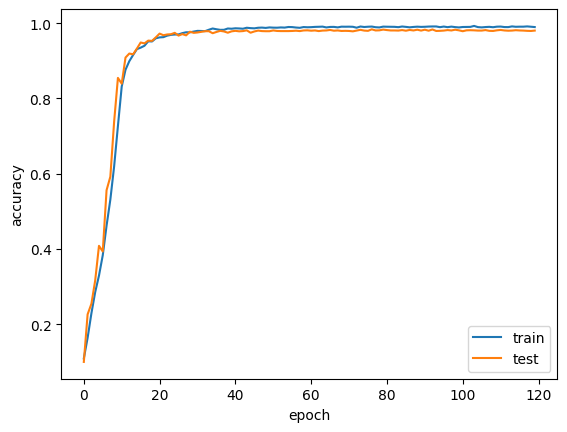

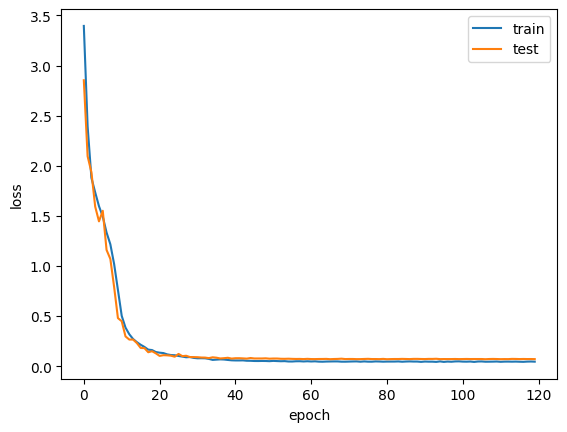

In [11]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [12]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet50_MINST-DVS_Hardtanh_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug.csv')

In [13]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.109571,0.100333,3.395854,2.853769
1,0.164286,0.226667,2.394451,2.095108
2,0.229286,0.254667,1.879825,1.936949
3,0.285714,0.316667,1.735023,1.592703
4,0.329571,0.408667,1.596651,1.445521
